# Tuberculosis Treatment Abandonment Classifier
O dataset utilizado nesse projeto contém casos de tuberculose pulmonar reportados ao Sistema de Informação de Agravos de Notificação (SINAN) entre 2015 e 2022. Dessa forma, faremos uma análise dos dados para tentar entender certos padrões e quais fatores estão mais associados ao caso da não-finalização do tratamento da tuberculose, ou seja, do abandono do tratamento. Após a analise, treinaremos um modelo classificador.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier

### Carregando o dataset

In [14]:
# df = pd.read_csv('data/casos_tuberculose_2015-2022.csv')
# df = df.drop(['tp_not','id_agravo','dt_notific','nu_ano','id_municip','id_regiona','dt_diag','ano_nasc','nu_idade_n','sg_uf','id_mn_resi','id_rg_resi','id_pais','nduplic_n','in_vincula','dt_digita','dt_transus','dt_transdm','dt_transsm','dt_transrm','dt_transrs','dt_transse','cs_flxret','flxrecebi','migrado_w','id_ocupa_n','institucio','teste_tube','extrapu1_n','extrapu2_n','extrapul_o','agravoutra','agravoutde','bacilosc_e','bacilos_e2','bacilosc_o','cultura_ou','histopatol','dt_inic_tr','rifampicin','isoniazida','etambutol','estreptomi','pirazinami','etionamida','outras','outras_des','nu_contato','doenca_tra','sg_uf_at','id_munic_a','dt_noti_at','sg_uf_2','id_munic_2','bacilosc_1','bacilosc_2','bacilosc_3','bacilosc_4','bacilosc_5','bacilosc_6','dt_mudanca','nu_comu_ex','situa_9_m','situa_12_m','dt_encerra','tpuninot','test_molec','test_sensi','ant_retro','bac_apos_6','transf','uf_transf','mun_transf','time_in_SINAN','cultura_es','trat_super','cs_gestant','situa_ence','pop_liber','pop_rua','pop_saude','pop_imig','forma'], axis=1)

# df.rename(columns={'sg_uf_not': 'reg_not'}, inplace=True)
# df['reg_not'] = df['reg_not'].replace({'North': 0, 'NorthEast': 1, 'South': 2, 'SouthEast': 3, 'Central-west': 4})
# df['raiox_tora'] = df['raiox_tora'].replace({np.NaN:2}) # Valores nulos considerados como raio-x não realizado
# df['agravaids'] = df['agravaids'].replace({2:0, 3:np.NaN, 9:np.NaN})
# df['hiv'] = df['hiv'].replace({np.NaN:2}) # Valores nulos considerados como teste HIV não realizado
# df.rename(columns={'outcome': 'abandono'}, inplace=True)
# df.head()

/tmp/ipykernel_10248/3599924221.py:1: DtypeWarning: Columns (22,24,29,30,32,49,54,60,76,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/casos_tuberculose_2015-2022.csv')
/tmp/ipykernel_10248/3599924221.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['reg_not'] = df['reg_not'].replace({'North': 0, 'NorthEast': 1, 'South': 2, 'SouthEast': 3, 'Central-west': 4})


,reg_not,cs_sexo,cs_raca,cs_escol_n,tratamento,raiox_tora,agravaids,agravalcoo,agravdiabe,agravdoenc,hiv,tratsup_at,benef_gov,agravdroga,agravtabac,idade,abandono
0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,1.0,60.0,0
1,1.0,1.0,1.0,0.0,1.0,1.0,NaN,1.0,NaN,NaN,2.0,0.0,0.0,NaN,NaN,37.0,1
2,2.0,1.0,1.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,NaN,22.0,1
3,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,1.0,1.0,37.0,0
4,3.0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,NaN,NaN,0.0,1.0,1.0,1.0,1.0,22.0,1


### Lidando com dados faltantes

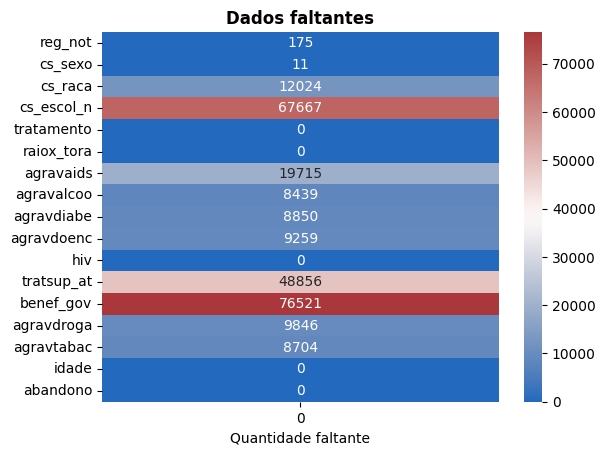

In [15]:
# plt.title('Dados faltantes',fontweight='bold')
# ax = sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
# ax.set_xlabel('Quantidade faltante')
# plt.show()

Nossa base de dados possui uma grande quantidade de dados faltantes, portanto vamos utilizar o método da imputação iterativa com um classificador de árvore de decisão para preencher os dados, sabendo que os dados são todos categóricos.

In [16]:
# Imputador iterativo com um classificador de árvore de decisão
# iterative_imputer = IterativeImputer(estimator=DecisionTreeClassifier(), random_state=42)
# df_imputed = pd.DataFrame(iterative_imputer.fit_transform(df), columns=df.columns)

Vamos salvar o dataframe imputado para não precisar rodar o imputador novamente. Usaremos ele para analisar os dados e para treinar o modelo.

In [17]:
# df_imputed.to_csv("data/tuberculose_imputed.csv", index=False)

In [18]:
df = pd.read_csv('data/tuberculose_imputed.csv')
# Otimização de memória
for column in df.columns:
    df[column] = df[column].astype(np.int8)

### Exploração dos dados

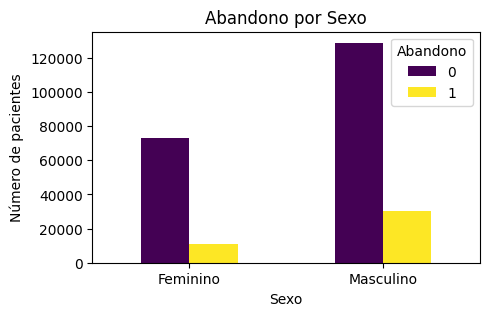

In [19]:
# Contar os casos de abandono por status de HIV
counts = df.groupby(['cs_sexo', 'abandono']).size().unstack()
counts.columns = ['0', '1']
counts.index = ['Feminino', 'Masculino']

# Plotar o gráfico de barras
counts.plot(kind='bar', stacked=False, figsize=(5, 3), colormap='viridis')

# Adicionar linhas horizontais e valores no eixo y
for value in ax.get_yticks():
    ax.axhline(y=value, color='gray', linestyle='--', linewidth=0.7)
    ax.text(-0.3, value, str(int(value)), color='gray', fontsize=10, va='center')

plt.title('Abandono por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Número de pacientes')
plt.xticks(rotation=0)
plt.legend(title='Abandono')
plt.show()

Nota-se que quase o dobro dos casos são em homens e, percentualmente, não há grande diferença dos casos de abandono.  
13% dos pacientes do sexo feminino abandonaram o tratamento.  
19% do sexo masculino abandonaram. 

In [20]:
abandono_por_sexo = df.groupby(['abandono', 'cs_sexo']).size().unstack()
abandono_por_sexo.columns = ['FEM', 'MASC']
for column in abandono_por_sexo.columns:
        print(f"Valores na coluna '{column}':")
        value_counts = abandono_por_sexo[column].value_counts(dropna=False)  # Conta os valores, incluindo NaNs
        value_percent = abandono_por_sexo[column].value_counts(normalize=True, dropna=False) * 100  # Conta percentual dos valores, incluindo NaNs
        value_counts_df = pd.DataFrame({'Quantidade': value_counts, 'Percentual (%)': value_percent})
        print(value_counts_df)
        print("\n")

Valores na coluna 'FEM':
       Quantidade  Percentual (%)
FEM                              
73380           1            50.0
11002           1            50.0


Valores na coluna 'MASC':
        Quantidade  Percentual (%)
MASC                              
128973           1            50.0
30371            1            50.0


